In [5]:
# Imports
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time

# Custom functions
import dataload
import transform

In [8]:
# Settings

all_names = [
    'ADGU101504',
    'ALUR012904',
    'BECA011405',
    'BRCA062405',
    'BRLO041102',
    'BTOL083105',
    'BTOL090105',
    'CAPO092605',
    'CRCA020205',
    'ESCI031905',
    'TAGO061203']

path_rec = "ssdata/register/"
rec_postamble = ".rec"

path_marks = "ssdata/label/marks/"
marks_preamble = "FixedSS_"
marks_postamble = ".txt"

path_states = "ssdata/label/states/"
states_preamble = "StagesOnly_"
states_postamble = ".txt"

params = {
    'channel': 1,             # Channel to be used
    'dur_epoch': 30,          # Time of window page [s]
    'n2_val': 3,              # N2 state coding value
    'context': 1.28,          # Length of context for timestep, in [s]
    'factor_border': 1,
    # spectrogram will be computed in a segment of length (factor_border+1)*context to avoid border effects
    'mark_smooth': 1          # Number of samples to average at the center to get the segment central mark.
    # 'dur_min_ss': 0.3,      # Min SS duration [s]
    # 'dur_max_ss': 3.0       # Max SS duration [s]
}

In [10]:
# Read first register
signal_list = []
marks_list = []
states_list = []
for i in range(1):
    # Read EEG Signal
    path_edf_file = path_rec + all_names[i] + rec_postamble
    signal, fs = dataload.read_eeg(path_edf_file, params['channel'])
    signal_list.append(signal)
    # Read Expert marks
    path_marks_file = path_marks + marks_preamble + all_names[i] + marks_postamble
    marks = dataload.read_marks(path_marks_file, params['channel'])
    marks_list.append(marks)
    # Read states
    path_states_file = path_states + states_preamble + all_names[i] + states_postamble
    states = dataload.read_states(path_states_file)
    states_list.append(states)    
params['fs'] = fs           # Save sampling frequency [Hz]

print(len(signal_list), ' EEG signals have been read.')
print(len(marks_list), ' sleep spindle marks files have been read.')
print(len(states_list), ' state annotations files have been read.')
print('Sampling Frequency: ', fs, 'Hz')

1  EEG signals have been read.
1  sleep spindle marks files have been read.
1  state annotations files have been read.
Sampling Frequency:  200 Hz


Chosen epoch: 31


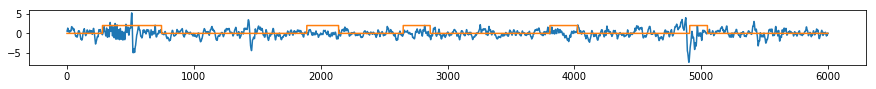

length of mini_signal is 512
central sample: 0.08919284642345487
central sample: 0.08919284642345487


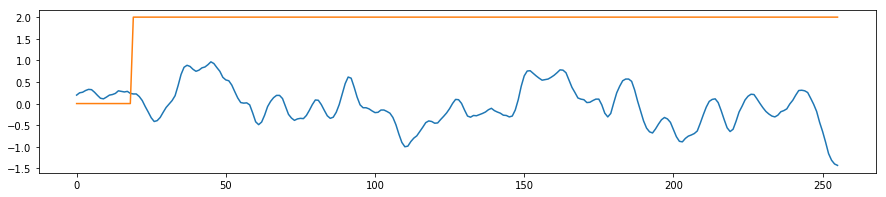

In [198]:
# first n2 epoch
signal = signal_list[0]
states = states_list[0]
marks = marks_list[0]
marks = transform.inter2seq(marks, 0, len(signal) - 1)

useful = np.where(states == params["n2_val"])
epoch = useful[0][3]
print("Chosen epoch: "+str(epoch))

# get segment
sample_start = epoch * params['dur_epoch'] * params['fs']
sample_end = (epoch + 1) * params['dur_epoch'] * params['fs']
segment_signal = signal[sample_start:sample_end]
segment_marks = marks[sample_start:sample_end]

# Normalize signal
segment_signal = (segment_signal - np.mean(segment_signal)) / np.std(segment_signal)

# Show segment
plt.figure(figsize=(15, 1))
plt.plot(segment_signal)
plt.plot(2*segment_marks)
plt.show()

# Mini segment
central_sample = 2000
sample_start = central_sample - int( (params['factor_border']+1)*params['context']*params['fs']/2 )
sample_end = central_sample + int( (params['factor_border']+1)*params['context']*params['fs']/2 )
mini_signal = segment_signal[sample_start:sample_end]
mini_marks = segment_marks[sample_start:sample_end]
print("length of mini_signal is", len(mini_signal))
print('central sample:', segment_signal[central_sample])
print('central sample:', mini_signal[int(len(mini_signal)/2)])
# Plot mini segment
plt.figure(figsize=(15, 3))
plt.plot(mini_signal[128:384])
plt.plot(2*mini_marks[128:384])
plt.show()

32
[ 2.82842712  3.08442165  3.36358566  3.66801617  4.          4.36203093
  4.75682846  5.18735822  5.65685425  6.1688433   6.72717132  7.33603235
  8.          8.72406186  9.51365692 10.37471644 11.3137085  12.3376866
 13.45434264 14.67206469 16.         17.44812372 19.02731384 20.74943287
 22.627417   24.67537321 26.90868529 29.34412938 32.         34.89624745
 38.05462768 41.49886575]
[35.35533906 32.42098887 29.73017788 27.26269332 25.         22.92510108
 21.02241038 19.27763532 17.67766953 16.21049443 14.86508894 13.63134666
 12.5        11.46255054 10.51120519  9.63881766  8.83883476  8.10524722
  7.43254447  6.81567333  6.25        5.73127527  5.2556026   4.81940883
  4.41941738  4.05262361  3.71627223  3.40783666  3.125       2.86563764
  2.6278013   2.40970441]
(32, 512)


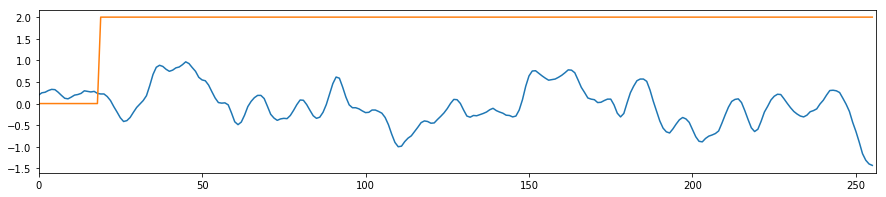

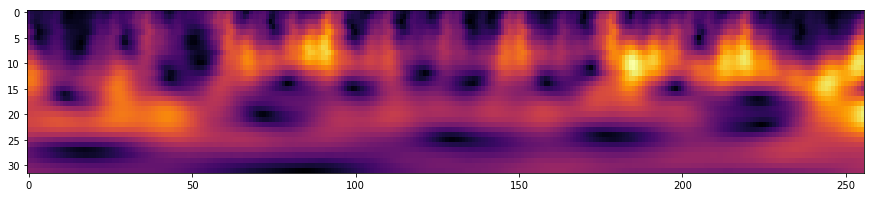

In [280]:
# Get CWT

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pywt


# CMorlet
J0 = 2.5 # Initial octave
J = 3 # Number of octaves
Q = 8 # Number of scales per octave
scales = np.power(2, np.arange(J0*Q, J0*Q + 2**np.ceil(np.log2(J*Q)))/Q )
#print(len(scales))
#print(scales)

w = pywt.ContinuousWavelet('cmor')
w.center_frequency = 1
w.bandwidth_frequency = 2

coef, freqs = pywt.cwt(mini_signal, scales, w, 1/200)


# CGAU
J0 = 1.5 # Initial octave
J = 3 # Number of octaves
Q = 8 # Number of scales per octave
scales = np.power(2, np.arange(J0*Q, J0*Q + 2**np.ceil(np.log2(J*Q)))/Q )
print(len(scales))
print(scales)

coef, freqs = pywt.cwt(mini_signal, scales, 'cgau4', 1/200)


abs_coef = np.abs(coef)
abs_coef = (abs_coef - np.min(abs_coef)) /(np.max(abs_coef) - np.min(abs_coef))
print(freqs)
print(abs_coef.shape)

# Plot mini segment
plt.figure(figsize=(15, 3))
plt.plot(mini_signal[128:384])
plt.plot(2*mini_marks[128:384])
plt.xlim(0, 256)
plt.show()

#plt.figure(figsize=(15, 3))
#plt.matshow(abs_coef[:, 128:384] * freqs[:, np.newaxis])  # show matrix
#plt.show()

plt.figure(figsize=(15, 3))
plt.imshow(abs_coef[:, 128:384] * freqs[:, np.newaxis], interpolation='nearest', cmap=cm.inferno, aspect='auto')
plt.show()

In [274]:
#pywt.families(short=False)

#pywt.families(short=True)

pywt.wavelist(family=None, kind='continuous')

#wavelet = pywt.ContinuousWavelet('gaus1')
#print(wavelet)
#np.min([[1,2,3],[0,1,1]])

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

Chosen epoch: 33
0.0006691268055527697
[35.35533906 32.42098887 29.73017788 27.26269332 25.         22.92510108
 21.02241038 19.27763532 17.67766953 16.21049443 14.86508894 13.63134666
 12.5        11.46255054 10.51120519  9.63881766  8.83883476  8.10524722
  7.43254447  6.81567333  6.25        5.73127527  5.2556026   4.81940883
  4.41941738  4.05262361  3.71627223  3.40783666  3.125       2.86563764
  2.6278013   2.40970441]
(32, 6000)


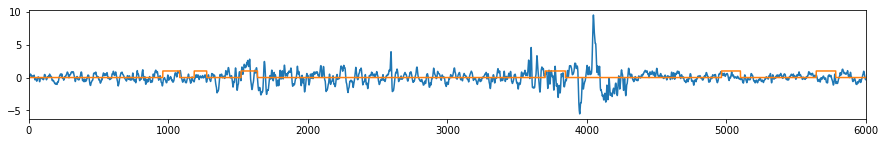

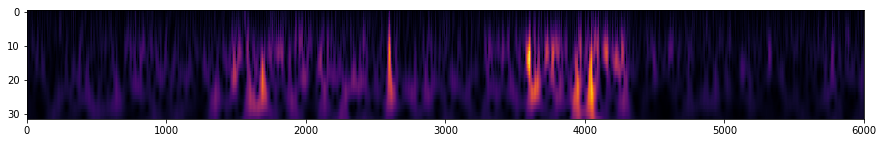

In [281]:
# CWT of the entire segment

import matplotlib.cm as cm


# first n2 epoch
signal = signal_list[0]
states = states_list[0]
marks = marks_list[0]
marks = transform.inter2seq(marks, 0, len(signal) - 1)

useful = np.where(states == params["n2_val"])
epoch = useful[0][5]
print("Chosen epoch: "+str(epoch))

# get segment
sample_start = epoch * params['dur_epoch'] * params['fs']
sample_end = (epoch + 1) * params['dur_epoch'] * params['fs']
segment_signal = signal[sample_start:sample_end]
segment_marks = marks[sample_start:sample_end]

# Normalize signal
segment_signal = (segment_signal - np.mean(segment_signal)) / np.std(segment_signal)


# CWT of the entire segment
coef, freqs = pywt.cwt(segment_signal, scales,'cgau4', 1/200)
abs_coef = np.abs(coef)
#abs_coef = (abs_coef - np.min(abs_coef)) /(np.max(abs_coef) - np.min(abs_coef))
print(np.min(abs_coef))
print(freqs)
print(abs_coef.shape)

# Plot mini segment
plt.figure(figsize=(15, 2))
plt.plot(segment_signal)
plt.plot(segment_marks)
plt.xlim(0, 6000)
plt.show()

regular_values = abs_coef * freqs[:, np.newaxis]
log_values = np.log10(regular_values + 1e-8) 
clip_log = np.clip(log_values, -1, None)


plt.figure(figsize=(15, 2))
plt.imshow(regular_values, interpolation='nearest', cmap=cm.inferno, aspect='auto')
#plt.matshow(abs_coef * freqs[:, np.newaxis])  # show matrix
plt.show()

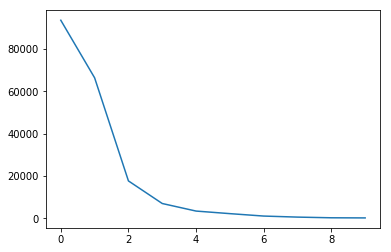

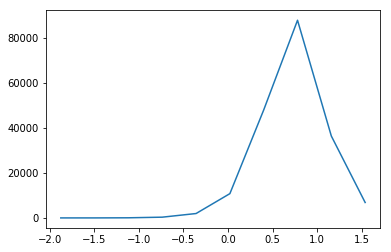

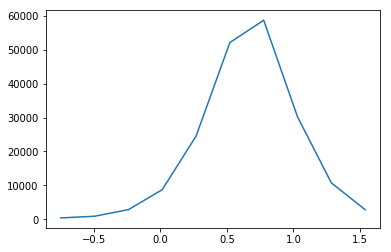

In [240]:
regular_values = abs_coef * freqs[:, np.newaxis]
hist, bin_edges = np.histogram(regular_values)
plt.plot(hist)
plt.show()

log_values = np.log10(regular_values + 1e-8) 
clip_log = np.clip(log_values, -1, None)

hist, bin_edges = np.histogram(log_values)
plt.plot(bin_edges[1:], hist)
plt.show()

hist, bin_edges = np.histogram(clip_log)
plt.plot(bin_edges[1:], hist)
plt.show()